In [1]:
import numpy as np
import torch, torchvision

In [2]:
import os

In [3]:
import PIL

In [4]:
import sys
sys.path.append('..')

In [5]:
from backend.ml.models import BeheadedDenseNet121, calc_embed, fix_PIL_img_shape

In [6]:
_model = BeheadedDenseNet121()
_model = _model.train(False)

In [12]:
e = calc_embed(_model, '/Users/sergmiller/Downloads/left/00002.jpg')

In [7]:
BeheadedDenseNet121().output_embeddings_shape()

1024

In [25]:
e = calc_embed(model, '/Users/sergmiller/Downloads/left/00002.jpg')

In [8]:
get_jpgs = lambda p: sorted([f for f in os.listdir(p) if f[-3:] == 'jpg'])

In [9]:
import numpy as np

files = get_jpgs('/Users/sergmiller/Downloads/left')
print(files[:10])
np.random.seed(0)
np.random.shuffle(files)
print(files[:10])

['00000.jpg', '00001.jpg', '00002.jpg', '00003.jpg', '00004.jpg', '00005.jpg', '00006.jpg', '00007.jpg', '00008.jpg', '00009.jpg']
['04990.jpg', '03044.jpg', '05571.jpg', '03847.jpg', '02828.jpg', '04684.jpg', '04172.jpg', '02426.jpg', '04165.jpg', '04571.jpg']


In [10]:
len(files)

6016

In [11]:
train_files = files[:5000]
val_files = files[5000:5500]
test_files = files[5500:6016]

In [7]:
from torch.utils.data import Dataset, DataLoader

In [8]:
class PairedDatasetWithNegativesMiner(Dataset):
    def __init__(self, paired_ids, processor):
        self.processor = processor
        self.paired_ids = paired_ids

    def __len__(self):
        return len(self.paired_ids)


    def __getitem__(self, idx):
        left_item = self.processor(self.paired_ids[idx][0])
        right_item = self.processor(self.paired_ids[idx][1])
        return {'left': left_item, 'right': right_item, 'target': torch.Tensor([1.0])}

    @staticmethod
    def collateBatchWithNegatives(items, score, top=None):
        N = len(items)
        add_sqr = N * (N - 1)
        if top is None:
            top = add_sqr
        top = min(top, add_sqr)
        scores = np.ones(N ** 2) * (-np.inf)
        for i in np.arange(N):
            for j in np.arange(N):
                if i == j:
                    continue
                scores[i * N + j] = score(items[i]['left'], items[j]['right'])

        order = np.argsort(scores)[::-1]
        left_negatives, right_negatives = np.unravel_index(order[:top], (N, N))
        negatives = {'left': left_negatives, 'right': right_negatives}

        concat_to_batch_f = lambda side: \
            [items[i][side] for i in np.arange(N)] + [items[negatives[side][i]][side] for i in np.arange(top)]

        left_tensor = torch.FloatTensor(concat_to_batch_f('left'))
        right_tensor = torch.FloatTensor(concat_to_batch_f('right'))
        targets = torch.Tensor(np.concatenate([np.ones(N), np.zeros(top)])).reshape(-1,1)
        return {'left': left_tensor, 'right': right_tensor, 'target': targets}

In [9]:
def processor(image):
    e = _model(image)
    return np.array(e.detach())

In [16]:
def open_files(files):
    return [fix_PIL_img_shape(PIL.Image.open(f)) for f in files]

In [17]:
common_path = '/Users/sergmiller/Downloads/'
paired_imgs = lambda imgs, side : open_files([os.path.join(common_path, side, f) for f in imgs])

In [340]:
%%time
train_imgs = [(l,r) for l,r in zip(paired_imgs(train_files, 'left'),  paired_imgs(train_files, 'right'))]

CPU times: user 15.3 s, sys: 3.57 s, total: 18.8 s
Wall time: 28.5 s


In [424]:
def process_paired_imgs(imgs):
    l = [_i[0] for _i in imgs]
    r = [_i[1] for _i in imgs]
    from joblib import Parallel, delayed
    b = 10
    def calc(_f,_g):
        _embeds = []
        for f,g in zip(_f,_g):
            _embeds.append([processor(f), processor(g)])
        return _embeds
    with Parallel(n_jobs=4) as parallel:
        embeds = parallel(delayed(calc)(l[i:i+b],r[i:i+b]) for i in tqdm.tqdm(np.arange(0, len(imgs), b), position=0))
    flat_embeds = []
    for e in embeds:
        flat_embeds.extend(e)
        
    return flat_embeds

In [425]:
train_embeds = process_paired_imgs(train_imgs)

100%|██████████| 500/500 [24:07<00:00,  2.90s/it]


In [439]:
sum(train_embeds[5][1])

104.92741574909525

In [440]:
# np.save('train_pairs_embeds.npy', train_embeds)

In [10]:
train_embeds = np.load('train_pairs_embeds.npy')

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

[ 8.6278626e-05 -6.1798254e-03  3.8459913e-03 ...  4.9378628e-01
  6.6927902e-02 -5.5560929e-01]


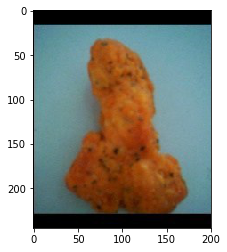

[2.3362561e-04 4.8061178e-04 2.6766786e-03 ... 3.8715997e-01 1.1659704e+00
 1.0502260e+00]


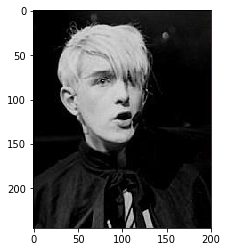

[-4.3098102e-05  6.0945409e-03  2.0097496e-03 ...  2.5351980e+00
 -2.7927455e-01  5.1903229e-02]


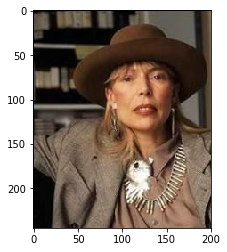

[ 9.7825564e-04  1.4810020e-03  5.8621662e-03 ...  1.1456454e+00
  1.4859035e+00 -8.7631428e-01]


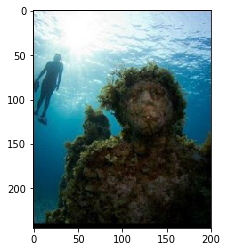

In [409]:
i = 0
for x in paired_imgs(val_files, 'left'):
    i += 1
    if i == 5:
        break
    plt.imshow(x)
    print(processor(x))
    plt.show()

In [342]:
%%time
val_imgs = [(l,r) for l,r in zip(paired_imgs(val_files, 'left'),  paired_imgs(val_files, 'right'))]

CPU times: user 1.76 s, sys: 466 ms, total: 2.23 s
Wall time: 3.3 s


In [441]:
val_embeds = process_paired_imgs(val_imgs)

100%|██████████| 50/50 [01:06<00:00,  1.34s/it]


In [443]:
np.save('val_pairs_embeds.npy', val_embeds)

In [12]:
val_embeds = np.load('val_pairs_embeds.npy')

In [13]:
def make_data_reader(
        ids,
        model,
        processor,
        shuffle,
        batch_size=None,
        top_negatives=None
    ):
    dataset = PairedDatasetWithNegativesMiner(ids, processor)
    if batch_size is None:
        batch_size = len(dataset)
    return torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True,
        num_workers=4,
        collate_fn=lambda b:\
            PairedDatasetWithNegativesMiner.collateBatchWithNegatives(
                b, lambda l,r: torch.sum(model(torch.FloatTensor(l.reshape(1,-1))) * model(torch.FloatTensor(r.reshape(1,-1)))).item()
            , top_negatives
            )
        )

In [57]:
from copy import deepcopy
import tqdm

from itertools import chain

In [128]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [132]:
def train(args, model):
    out = torch.nn.Linear(1,1).train(True)
    torch.nn.init.constant_(out.weight, 0.0)
    torch.nn.init.constant_(out.bias, -3.434)  # -ln(1/ (1/32) - 1)
    
    def compute_loss(batch):
        left_batch = torch.FloatTensor(batch['left'].float())
        right_batch = torch.FloatTensor(batch['right'].float())
        target_batch = torch.FloatTensor(batch['target'].float())

        left_batch = left_batch.to(args.device)
        right_batch = right_batch.to(args.device)
        target_batch = target_batch.to(args.device)
        start_counter = time.perf_counter()
        normed_predict =  out(torch.mean(model(left_batch) * model(right_batch), dim=1).reshape(-1, 1))
        elapsed_time = time.perf_counter() - start_counter
#         print(left_batch.shape, right_batch.shape, target_batch.shape)
#         print(normed_predict, target_batch)
        return torch.nn.BCEWithLogitsLoss()(normed_predict, target_batch), normed_predict, elapsed_time

    opt = torch.optim.Adam(chain(model.parameters(),out.parameters()), args.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt,T_max=args.epoches)

    forward_pass_time = []
    backward_pass_time = []

    epoch_time = []
    batch_time = []

    import time

    for epoch in np.arange(args.epoches):
        train_loss = []
        val_loss = []
        val_roc_auc = []
        val_prc_auc = []

        start_epoch_time = time.time()
        model.train(True)
        fp_time = []
        bp_time = []
        frozen_model = deepcopy(model).to('cpu')
        frozen_model.train(False)

        train_batch = make_data_reader(train_embeds, model, lambda x:x, True, args.batch_size, args.train_negatives)

        for batch in tqdm.tqdm(train_batch, position=0):
            start_batch_time = time.time()
            # train on batch
            loss, predict, fp = compute_loss(batch)
            fp_time.append(fp)
            start_counter = time.perf_counter()
            loss.backward()
            bp_time.append(time.perf_counter() - start_counter)
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            batch_time.append(time.time() - start_batch_time)


        scheduler.step()
        forward_pass_time.append(np.mean(fp_time))
        backward_pass_time.append(np.mean(bp_time))


        model.train(False) # disable dropout / use averages for batch_norm

        val_batch = make_data_reader(val_embeds, model, lambda x:x, False, args.batch_size)

        for batch in tqdm.tqdm(val_batch, position=0):
            loss, predict, _ = compute_loss(batch)
            val_roc_auc.append(roc_auc_score(batch['target'].cpu().data.numpy().reshape(-1), predict.cpu().data.numpy().reshape(-1)))
            val_prc_auc.append(average_precision_score(batch['target'].cpu().data.numpy().reshape(-1), predict.cpu().data.numpy().reshape(-1)))
            val_loss.append(loss.cpu().data.numpy())
            
        mean_train_loss, mean_val_loss, mean_roc_auc, mean_prc_auc = np.mean(train_loss), np.mean(val_loss), np.mean(val_roc_auc), np.mean(val_prc_auc)

        epoch_time.append(time.time() - start_epoch_time)
        print("Epoch {}/{}: train loss: {}, val loss: {} val roc auc: {}, val prc auc: {}"\
                .format(epoch + 1, args.epoches,
                        mean_train_loss,
                        mean_val_loss,
                        mean_roc_auc,
                        mean_prc_auc
                )
        )

        if (epoch + 1) % args.out_save_freq == 0 or epoch + 1 == args.epoches:
            path = '{}/prc_{}_roc_{}_val_{}_train_{}_epoch_{}_out_{}_{}'.format(
                os.path.join(args.log_dir),
                mean_prc_auc,
                mean_roc_auc,
                mean_val_loss,
                mean_train_loss,
                epoch + 1,
                out.weight.item(),
                out.bias.item()
            )
            save_model(path, model)

        if args.print_profile_stats:
            print("Mean time per epoch: {}s".format(round(np.mean(epoch_time), 2)))
            print("Mean time per batch: {}s".format(round(np.mean(batch_time), 2)))
            if str(args.device)[:4] == 'cuda':
                print("Peak memory usage by Pytorch tensors: {} Mb"\
                        .format(round(torch.cuda.max_memory_allocated() / 1024 / 1024, 2)))


def save_model(path, model):
    torch.save(model.state_dict(), path)

In [ ]:
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

In [139]:
class args:
    learning_rate = 1e-3
    batch_size=32
    epoches=50
    print_profile_stats=True
    out_save_freq=1
    log_dir='logs_3_layer_model'
    device='cpu'
    train_negatives=None

In [140]:
model = torch.nn.Sequential(
    torch.nn.Linear(_model.output_embeddings_shape(), 256),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(256, 256),
    torch.nn.LayerNorm(256,elementwise_affine=False)
)

# model = torch.nn.Sequential(
#     torch.nn.Linear(_model.output_embeddings_shape(), 256),
#     torch.nn.Dropout(p=0.1),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(256, 256),
#     torch.nn.LeakyReLU(),
#     torch.nn.Linear(256, 256),
#     torch.nn.LayerNorm(256,elementwise_affine=False)
# )

train(args, model)

  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 1/50: train loss: 0.13788193464279175, val loss: 0.13655321300029755 val roc auc: 0.7271851898521506, val prc auc: 0.1027089953453936
Mean time per epoch: 61.07s
Mean time per batch: 0.19s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 2/50: train loss: 0.13554500043392181, val loss: 0.13506749272346497 val roc auc: 0.7192414314516129, val prc auc: 0.1100247344192669
Mean time per epoch: 61.55s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 3/50: train loss: 0.13323268294334412, val loss: 0.13274113833904266 val roc auc: 0.7510658182123655, val prc auc: 0.13219576137121128
Mean time per epoch: 59.66s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 4/50: train loss: 0.13108043372631073, val loss: 0.13099414110183716 val roc auc: 0.766727570564516, val prc auc: 0.1249821664824991
Mean time per epoch: 58.97s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 5/50: train loss: 0.12834133207798004, val loss: 0.12880939245224 val roc auc: 0.7844590053763442, val prc auc: 0.14142088598739103
Mean time per epoch: 58.71s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 6/50: train loss: 0.12570731341838837, val loss: 0.12842310965061188 val roc auc: 0.7679855510752689, val prc auc: 0.13847595429769333
Mean time per epoch: 57.69s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 7/50: train loss: 0.12301360815763474, val loss: 0.12637361884117126 val roc auc: 0.7835433467741936, val prc auc: 0.1430033574146229
Mean time per epoch: 56.92s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 8/50: train loss: 0.12032350897789001, val loss: 0.12538987398147583 val roc auc: 0.7841040826612904, val prc auc: 0.13910789403590623
Mean time per epoch: 57.29s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 9/50: train loss: 0.11815574765205383, val loss: 0.12503349781036377 val roc auc: 0.7811754452284946, val prc auc: 0.15179165958145507
Mean time per epoch: 57.06s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 10/50: train loss: 0.1152758002281189, val loss: 0.12362615764141083 val roc auc: 0.7881552419354839, val prc auc: 0.15534598360121504
Mean time per epoch: 56.76s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 11/50: train loss: 0.11274135857820511, val loss: 0.12299264222383499 val roc auc: 0.7899529569892475, val prc auc: 0.15216593194266212
Mean time per epoch: 56.56s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 12/50: train loss: 0.11000365763902664, val loss: 0.12337010353803635 val roc auc: 0.7804813508064518, val prc auc: 0.16174978775261992
Mean time per epoch: 56.75s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 13/50: train loss: 0.10772092640399933, val loss: 0.12279482185840607 val roc auc: 0.7816679267473119, val prc auc: 0.1552550688208369
Mean time per epoch: 56.51s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 14/50: train loss: 0.10540224611759186, val loss: 0.12218078970909119 val roc auc: 0.7831107190860215, val prc auc: 0.15415185073883733
Mean time per epoch: 56.27s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 15/50: train loss: 0.10304149240255356, val loss: 0.1225586012005806 val roc auc: 0.7781754032258064, val prc auc: 0.16208346428710432
Mean time per epoch: 55.98s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 16/50: train loss: 0.10098086297512054, val loss: 0.12296795845031738 val roc auc: 0.7717468918010754, val prc auc: 0.15452706129167276
Mean time per epoch: 55.69s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 17/50: train loss: 0.09849698841571808, val loss: 0.12303633987903595 val roc auc: 0.7706863239247312, val prc auc: 0.15851254923793803
Mean time per epoch: 55.5s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 18/50: train loss: 0.09647466242313385, val loss: 0.12253821641206741 val roc auc: 0.7732820900537636, val prc auc: 0.1549318671302188
Mean time per epoch: 55.33s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 19/50: train loss: 0.09450573474168777, val loss: 0.12391471862792969 val roc auc: 0.7626197076612903, val prc auc: 0.17125507683434255
Mean time per epoch: 55.2s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 20/50: train loss: 0.09251689910888672, val loss: 0.1238628625869751 val roc auc: 0.7576528897849462, val prc auc: 0.16975453617098932
Mean time per epoch: 55.04s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 21/50: train loss: 0.09052179753780365, val loss: 0.12465308606624603 val roc auc: 0.7504893313172043, val prc auc: 0.1636541624288629
Mean time per epoch: 54.91s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 22/50: train loss: 0.08856604993343353, val loss: 0.1235225573182106 val roc auc: 0.7580225134408602, val prc auc: 0.15450875347361467
Mean time per epoch: 54.79s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 23/50: train loss: 0.08705434948205948, val loss: 0.1239870935678482 val roc auc: 0.7562436995967743, val prc auc: 0.16404681401719828
Mean time per epoch: 54.66s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 24/50: train loss: 0.08482931554317474, val loss: 0.1239602193236351 val roc auc: 0.7579931115591397, val prc auc: 0.16661371310031034
Mean time per epoch: 54.53s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 25/50: train loss: 0.08319102972745895, val loss: 0.12366170436143875 val roc auc: 0.7575846354166667, val prc auc: 0.17304681641954564
Mean time per epoch: 54.48s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 26/50: train loss: 0.08153707534074783, val loss: 0.12383714318275452 val roc auc: 0.7561680947580646, val prc auc: 0.1651882307243272
Mean time per epoch: 54.49s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 27/50: train loss: 0.08003409951925278, val loss: 0.12437968701124191 val roc auc: 0.7501890120967742, val prc auc: 0.17191403330644178
Mean time per epoch: 54.41s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 28/50: train loss: 0.07847025245428085, val loss: 0.12409768253564835 val roc auc: 0.750707745295699, val prc auc: 0.17886346504782139
Mean time per epoch: 54.41s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 29/50: train loss: 0.07777324318885803, val loss: 0.1253846436738968 val roc auc: 0.7452515961021506, val prc auc: 0.16624847098981496
Mean time per epoch: 54.38s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 30/50: train loss: 0.07636041939258575, val loss: 0.125871479511261 val roc auc: 0.744388440860215, val prc auc: 0.16691387369517516
Mean time per epoch: 54.28s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 31/50: train loss: 0.07532179355621338, val loss: 0.12584254145622253 val roc auc: 0.7429204469086022, val prc auc: 0.17398392234357057
Mean time per epoch: 54.16s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 32/50: train loss: 0.07454543560743332, val loss: 0.12618184089660645 val roc auc: 0.7406334005376344, val prc auc: 0.17173679414870646
Mean time per epoch: 54.1s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 33/50: train loss: 0.07408706843852997, val loss: 0.1262851059436798 val roc auc: 0.7396547379032259, val prc auc: 0.16686872163188898
Mean time per epoch: 53.99s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 34/50: train loss: 0.07283954322338104, val loss: 0.12615394592285156 val roc auc: 0.7436260920698924, val prc auc: 0.16462563856626017
Mean time per epoch: 53.9s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 35/50: train loss: 0.07216877490282059, val loss: 0.12656621634960175 val roc auc: 0.7395434307795699, val prc auc: 0.1645196493787318
Mean time per epoch: 53.8s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 36/50: train loss: 0.07161513715982437, val loss: 0.126666858792305 val roc auc: 0.7418577788978494, val prc auc: 0.16423574566473997
Mean time per epoch: 53.69s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 37/50: train loss: 0.07101541012525558, val loss: 0.12659646570682526 val roc auc: 0.7413264448924731, val prc auc: 0.1716663250301433
Mean time per epoch: 53.63s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 38/50: train loss: 0.07066353410482407, val loss: 0.12704332172870636 val roc auc: 0.7377940188172045, val prc auc: 0.17201108467854273
Mean time per epoch: 53.59s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 39/50: train loss: 0.06976599246263504, val loss: 0.12672926485538483 val roc auc: 0.7400537634408603, val prc auc: 0.16969480952403376
Mean time per epoch: 53.52s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 40/50: train loss: 0.06950230151414871, val loss: 0.1272708624601364 val roc auc: 0.7360698084677418, val prc auc: 0.17320126047246773
Mean time per epoch: 53.46s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 41/50: train loss: 0.06927941739559174, val loss: 0.12702706456184387 val roc auc: 0.7384366599462363, val prc auc: 0.17528937753976154
Mean time per epoch: 53.4s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 42/50: train loss: 0.06900182366371155, val loss: 0.1271687000989914 val roc auc: 0.7380775369623654, val prc auc: 0.17249898105965394
Mean time per epoch: 53.38s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 43/50: train loss: 0.06893612444400787, val loss: 0.12737755477428436 val roc auc: 0.7360467069892473, val prc auc: 0.17007611881746196
Mean time per epoch: 53.33s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 44/50: train loss: 0.06843286752700806, val loss: 0.12733206152915955 val roc auc: 0.736032006048387, val prc auc: 0.17152691267134534
Mean time per epoch: 53.26s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 45/50: train loss: 0.06844662129878998, val loss: 0.12742100656032562 val roc auc: 0.7358072916666667, val prc auc: 0.17244977386650964
Mean time per epoch: 53.22s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 46/50: train loss: 0.06787953525781631, val loss: 0.12738944590091705 val roc auc: 0.7356287802419353, val prc auc: 0.17486840620404417
Mean time per epoch: 53.15s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 47/50: train loss: 0.06810388714075089, val loss: 0.1274062693119049 val roc auc: 0.7353977654569893, val prc auc: 0.17305023803742703
Mean time per epoch: 53.11s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 48/50: train loss: 0.06851442158222198, val loss: 0.12746773660182953 val roc auc: 0.7351016465053762, val prc auc: 0.17277189602727044
Mean time per epoch: 53.06s
Mean time per batch: 0.2s


  0%|          | 0/156 [00:00<?, ?it/s]

Epoch 49/50: train loss: 0.06781693547964096, val loss: 0.12746939063072205 val roc auc: 0.7351583501344087, val prc auc: 0.1728606273655849
Mean time per epoch: 53.05s
Mean time per batch: 0.2s


100%|██████████| 15/15 [00:04<00:00,  3.44it/s]

Epoch 50/50: train loss: 0.0681830644607544, val loss: 0.12747225165367126 val roc auc: 0.7350848454301074, val prc auc: 0.17292303267623862
Mean time per epoch: 53.07s
Mean time per batch: 0.2s
